The Titanic Kaggle Competition is the opening project to start. So just to say I've done it, here it is. Just a quick run through of the competition.

Double hashtags are explanative test and single hashtags are code

## Initial Data Import

In [91]:
## Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Scikit-Learn

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier

In [2]:
## Import Data

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
## We run into a practical vs theoretical conflict
## The test data should always stay dark but
## the data should be manipulated together and consistently

unsplit_data = train.append(test, ignore_index=True)

## We can find test data with the below code
## Just look for where we haven't given died or survived value.

# np.where(unsplit_data['Survived'].isnull())[0]

## Initial Exploration

We have missing data and have to fill it in. We can also see that we have 418 rows that are our test data

In [4]:
unsplit_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In order to get a sense of the data, we can look at some basic summary statistics. But keeping in mind that having empty values will shift the values

In [5]:
## Summary Statistics

train.dropna().describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,0.475410,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,0.754617,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


In order to plot the data we have to factorize them into numbers for python.

In [6]:
embarked_values = pd.factorize(train['Embarked'])

train['Embarked_value'] = embarked_values[0]

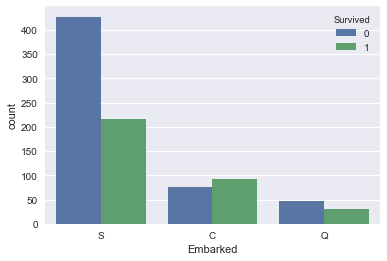

In [7]:
%matplotlib inline

sns.countplot(x = "Embarked", hue="Survived", data = train)

We can also see an effect on survived by other factors as well.

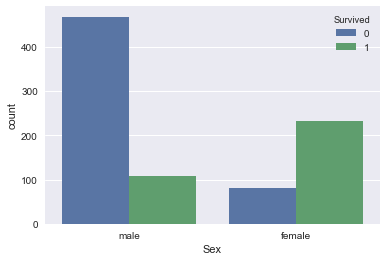

In [8]:
sns.countplot(x = "Sex", hue = "Survived", data = train)

   ## Dummify categoricals

We can also split the fares into 4 quantiles to help categorize people

In [9]:
fares = pd.qcut(unsplit_data['Fare'],4, labels=[0,1,2,3])

# fares.tolist().count(0)
# 323, 328, 320, 337

We need to create dummy variables in order to run scikit learn functions

In [10]:
Fares = pd.get_dummies(fares, prefix = "Fare")
Embarked = pd.get_dummies(unsplit_data['Embarked'], prefix = "Embarked")
Pclass = pd.get_dummies(unsplit_data['Pclass'], prefix = "Pclass")
Sex = pd.Series(np.where(unsplit_data['Sex'] == 'male', 1, 0), name = "Sex")

Then we can join all our dummified data and current data together

In [11]:
unsplit_dummied = pd.concat([Pclass, Sex, Embarked, Fares, unsplit_data[['Age','Parch','PassengerId','SibSp','Survived','Fare']]], axis = 1)

## Feature Engineering

We can take some less than clean data and create features we can use

#### Societal Status

In [12]:
titles = unsplit_data['Name'].str.extract('([A-z]+)\.', expand = False)

In [13]:
set(titles)

{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [14]:
title_map = {}

groupings = ["Millitary","Royalty","Professional","Regular"]
titles_grouped = [
    ["Capt", "Col", "Major",], 
    ['Jonkheer', 'Don', "Sir", "Countess", "Dona","Lady"],
    ['Dr', 'Rev'],
    ['Mme', 'Mlle', 'Ms', "Mr", "Mrs", "Miss", "Master"]]

The following code creates a key-value set that assigns each title a grouping

In [15]:
for grouping, grouped_title in zip(groupings,titles_grouped):
    for title in grouped_title:
        title_map[title] = grouping

We can now go through the data and map the grouping for each row of data

In [16]:
unsplit_data["Society"] = titles.map(title_map)

Now that we've created the feature (column), we can add it to the data

In [17]:
Society = pd.get_dummies(unsplit_data.Society, prefix="Society")

In [18]:
unsplit_dummied = pd.concat([unsplit_dummied, Society], axis = 1)

#### Cabin Class

In [19]:
Cabin_types = unsplit_data.Cabin.str.extract('([A-z]*)[0-9]*', expand = False)
Cabin_types = Cabin_types.fillna('Unk')

In [20]:
Cabin_types = pd.get_dummies(Cabin_types, prefix="Cabin_group")

In [21]:
unsplit_dummied = pd.concat([unsplit_dummied, Cabin_types], axis = 1)

Cabin Class is actually better defined as deck levels as we can find here. Sadly we're missing so much data in the data set we can't figure out where people were staying left-right and forward-back. But if you wanted to extract them you could use this regex.

https://www.encyclopedia-titanica.org/titanic-deckplans/c-deck.html

In [22]:
# raw_location = unsplit_data.Cabin.str.extract('[A-z]*([0-9]*)', expand = False)

#### Age

Let's try to impute the missing ages. We'll try linear regression, SVR, and kNN but they're pretty bad at it. I've left the last one - kNN to show how poorly they have been. I decided to stick with just doing the median age.

In [23]:
# This just grabs all the categories we want to try to use to predict age. 
# We need this because we dummified the categorical variables
categories_to_predict = [col for col in unsplit_dummied.columns if 'Pclass' in col or 'Sex' in col or 'Age' in col]


In [24]:
# Take the rows with age data only. I know, I know we're using test data too 
# but we're not trying to fill in survival but impute data.

# train data
data_with_ages = unsplit_dummied[categories_to_predict].dropna()

In [51]:
# Create the data whom's age we need to impute

# test data
na_ages_unfiltered = unsplit_dummied[unsplit_dummied['Age'].isnull()]
na_ages = na_ages_unfiltered[categories_to_predict]

In [52]:
# Fit out classifier
age_guess = KNeighborsClassifier()
age_guess.fit(data_with_ages.drop('Age', axis=1), np.round (np.ravel(data_with_ages[['Age']])) )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [56]:
# Comparing our predictions of training data
preds = pd.Series(np.round(age_guess.predict(data_with_ages.drop('Age', axis = 1))))


In [60]:
# How off are we on average. Not a great answer.
np.mean(np.array(data_with_ages[['Age']]) - np.array(preds))

17.913642447418738

In [89]:
# We have the median age but we'll not add it now

data_with_ages['Age'].median()

28.0

#### Ticket Info

The ticket info is a mess, almost as if they didn't have data scientists from the future in mind. So we first cleave out parts of the data and abstract ticket info to something reasonable. 

In [73]:
store = unsplit_data.Ticket.str.extract('(.*) ', expand = False)
store = store.fillna('Unk')

In [74]:
raw_ticket = store.map(lambda x: x.upper().replace('/',"").replace('.','') )

In [75]:
cleaned_ticket = raw_ticket.str.extract('([A-z]*)', expand=False)
cleaned_ticket.groupby(cleaned_ticket).count()

Ticket
A           39
AQ           2
AS           1
C            8
CA          68
CASOTON      1
FA           1
FC           3
FCC          9
LP           1
PC          92
PP           4
PPP          2
SC           2
SCA          3
SCAH         5
SCOW         1
SCPARIS     19
SOC          8
SOP          1
SOPP         7
SOTONO       3
SOTONOQ     24
SP           1
STONO       21
STONOQ       1
SWPP         2
UNK        961
WC          15
WEP          4
Name: Ticket, dtype: int64

In [81]:
ticket_dummies = pd.get_dummies(cleaned_ticket)

In [82]:
unsplit_dummied = pd.concat([unsplit_dummied, ticket_dummies], axis = 1)

#### Family Size

Is the size of your family something that affected your survival? Maybe that empathy affected you or maybe it helped. 

In [76]:
Family_count = unsplit_data['Parch'] + unsplit_data['SibSp']

In [77]:
def fam_size(x):
    if x == 0:
        return("Alone")
    elif 1<=x<=4:
        return("Normal")
    else:
        return("Large")

Family_count = Family_count.map(fam_size)

In [78]:
Fam_dummied = pd.get_dummies(Family_count, prefix="Family")

In [79]:
unsplit_dummied = pd.concat([unsplit_dummied, Fam_dummied], axis=1)

In [109]:
unsplit_dummied = unsplit_dummied.drop('Fare', axis = 1)

   ## Transform train and test equally

We've done the feature creation that we want, now we have to split the data up again into test and train.

In [111]:
# First we find the indicies of the test data
# Then we get all the indicies
# Finally we remove the test data indicies

test_indicies = np.where(unsplit_dummied['Survived'].isnull())[0]

train_indicies = list(range(len(unsplit_data))) 

train_indicies = np.delete(train_indicies, test_indicies)

In [112]:
# This splits the data into the test and train sets 

new_train = unsplit_dummied.iloc[train_indicies]
new_test = unsplit_dummied.iloc[test_indicies]

In [113]:
## Separate data in explanatory (X) and response (y)

y_train = new_train['Survived']
X_train = new_train.drop('Survived', axis=1)

X_test = new_test.drop('Survived', axis=1)

In [114]:
# We still have the age column to fill in with the median.

X_train.isnull().sum()

Pclass_1                  0
Pclass_2                  0
Pclass_3                  0
Sex                       0
Embarked_C                0
Embarked_Q                0
Embarked_S                0
Fare_0                    0
Fare_1                    0
Fare_2                    0
Fare_3                    0
Age                     177
Parch                     0
PassengerId               0
SibSp                     0
Society_Millitary         0
Society_Professional      0
Society_Regular           0
Society_Royalty           0
Cabin_group_A             0
Cabin_group_B             0
Cabin_group_C             0
Cabin_group_D             0
Cabin_group_E             0
Cabin_group_F             0
Cabin_group_G             0
Cabin_group_T             0
Cabin_group_Unk           0
Family_Alone              0
Family_Large              0
                       ... 
A                         0
AQ                        0
AS                        0
C                         0
CA                  

In [115]:
X_train['Age'] = X_train.fillna( X_train.Age.median())

X_test['Age'] = X_test.fillna( X_test.Age.median())

## Feature Selection

We made quite a few features now. But having so many features can make our classifiers work more poorly. So to do so we're going to do some feature selection as well.

In [116]:
# In order to pick which features are important we have to fit some classifier.
# I picked the ExtraTrees one

clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [117]:
# This records the importance of every feature

fet_sel = pd.DataFrame()
fet_sel['feature'] = X_train.columns
fet_sel['importance'] = clf.feature_importances_

In [118]:
# Here we sort them according to level

fet_sel.sort(['importance'], ascending=False)

/Users/sahir/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,feature,importance
13,PassengerId,0.316754
3,Sex,0.234978
12,Parch,0.041617
27,Cabin_group_Unk,0.032812
2,Pclass_3,0.032397
14,SibSp,0.031295
30,Family_Normal,0.019737
10,Fare_3,0.018467
11,Age,0.017723
0,Pclass_1,0.017593


In [120]:
# This takes the classifier we used and picks the features of most use.

model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
X_train_new.shape

(891, 14)

In [121]:
X_test_new = model.transform(X_test)
X_test_new.shape



(418, 14)

## Models

Now we have our dummified data with reduced features to use in our classification.

Decision Tree Classifier

In [131]:
DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_train_new, y_train)

DT_y_train_pred = DT.predict(X_train_new)
DT_y_test_pred = DT.predict(X_test_new)

DT_train_acc = np.sum(y_train == DT_y_train_pred)/len(y_train)
print(DT_train_acc)

0.805836139169


In [132]:
np.mean(cross_val_score(DT, X_train_new, y_train, cv = 10))

0.78339064805356939

Random Forest Classifier

In [133]:
RF = RandomForestClassifier(max_features="sqrt", 
                            max_depth=5, 
                            n_estimators=220, 
                            criterion="gini")

RF.fit(X_train_new, y_train)

RF_y_train_pred = RF.predict(X_train_new)
RF_y_test_pred = RF.predict(X_test_new)

RF_train_acc = np.sum(y_train == RF_y_train_pred)/len(y_train)
print(RF_train_acc)

0.835016835017


In [134]:
np.mean(cross_val_score(RF, X_train_new, y_train, cv = 10))

0.79128106911814777

AdaBoostClassifier

In [135]:
ABC = AdaBoostClassifier(n_estimators=5)
ABC.fit(X_train_new, y_train)

ABC_y_train_pred = ABC.predict(X_train_new)
ABC_y_test_pred = ABC.predict(X_test_new)

ABC_train_acc = np.sum(y_train == ABC_y_train_pred)/len(y_train)
print(ABC_train_acc)

0.781144781145


In [136]:
np.mean(cross_val_score(ABC, X_train_new, y_train, cv = 10))

0.78797242083758934

Logistic Regression

In [137]:
LR = LogisticRegression(C=1e4)
LR.fit(X_train_new, y_train)

LR_y_train_pred = LR.predict(X_train_new)
LR_y_test_pred = LR.predict(X_test_new)

LR_train_acc = np.sum(y_train == LR_y_train_pred)/len(y_train)
print(LR_train_acc)

0.805836139169


In [138]:
np.mean(cross_val_score(LR, X_train_new, y_train, cv = 10))

0.78120559527862887

ExtraTrees

In [140]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train_new, y_train)

clf_y_train_pred = clf.predict(X_train_new)
clf_y_test_pred = clf.predict(X_test_new)

clf_train_acc = np.sum(y_train == clf_y_train_pred)/len(y_train)
print(clf_train_acc)

1.0


In [141]:
np.mean(cross_val_score(clf, X_train_new, y_train, cv = 10))

0.75306548632391324

## Export Predictions

In [142]:
output_pred = pd.DataFrame({ 'PassengerID': X_test['PassengerId'], 
                            'Survived' : RF_y_test_pred.astype(int)
                           })

output_pred.to_csv( './data/predictions.csv', index = False)

This gives us a 0.73206 score on kaggle which is not too bad. We can pull up the score into the 0.8's but that requires much more work than reward. 